In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge

In [2]:
# --- Data Loading and Initial Exploration ---
df = pd.read_csv('data/marketing_spend_and_revenue_data.csv')

# Data Cleaning and Preparation
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.columns = df.columns.str.strip().str.replace(' ', '_')
df.head()

,Revenue,Google_Performance_Max,Google_Search_Brand,Google_Search_No_Brand,Facebook_Conversions,Facebook_Others,Facebook_Product_Catalog_Sales,Influencers,Display_Ads,TV_Ads,Radio_Ads,Magazine_Ads,Covid
Date,,,,,,,,,,,,,
2022-01-01,5796.714153,565.844985,322.220135,1362.108867,163.379921,152.275251,585.579521,486.459433,1326.028990,1702.230023,166.876823,599.465584,1
2022-01-02,5165.863043,458.498491,232.034662,1217.779342,240.671009,572.280788,367.558630,181.465092,761.528524,1082.458280,127.253406,319.817106,1
2022-01-03,6965.648769,673.987247,351.658849,1723.328306,777.660821,646.790367,443.272047,413.778807,421.681361,630.103186,192.637981,282.768261,1
2022-01-04,5710.922590,600.195659,253.768143,688.169972,580.639485,545.659219,375.149632,190.269984,244.705077,2318.640804,166.475016,412.040813,1
2022-01-05,4371.813951,456.867519,255.514027,835.129990,332.607431,449.809561,363.454579,294.213237,552.753741,2157.475018,127.684970,184.554535,1


In [3]:
df.describe()

,Revenue,Google_Performance_Max,Google_Search_Brand,Google_Search_No_Brand,Facebook_Conversions,Facebook_Others,Facebook_Product_Catalog_Sales,Influencers,Display_Ads,TV_Ads,Radio_Ads,Magazine_Ads,Covid
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,7900.774957,789.936482,392.411062,1078.169406,478.057189,550.112605,629.836776,275.546613,846.135791,1448.513381,238.025345,397.785930,0.073973
std,1430.141416,172.276270,85.953756,436.142312,183.960184,261.569706,143.046853,132.043304,383.768572,574.515785,52.202092,172.150649,0.262086
min,4095.786143,240.651050,158.528897,307.844420,150.019967,105.182794,264.070436,50.102167,206.021630,502.947644,84.875264,103.628226,0.000000
25%,6974.247316,671.008486,336.183785,737.041609,318.786045,341.917853,531.905607,164.601780,508.806322,955.499472,207.927612,252.634949,0.000000
50%,7915.844902,796.462406,396.050638,1067.670685,491.356199,545.659219,637.274431,273.633567,861.562291,1428.190319,237.792313,394.956728,0.000000
75%,8870.198709,913.110964,449.222336,1462.851808,640.452868,756.557406,714.792181,390.777340,1187.217741,1929.437667,275.749502,547.440270,0.000000
max,11667.224110,1319.046273,655.498198,1799.576510,797.852955,997.514110,1075.921842,499.736177,1498.560396,2496.695023,377.284762,699.734622,1.000000


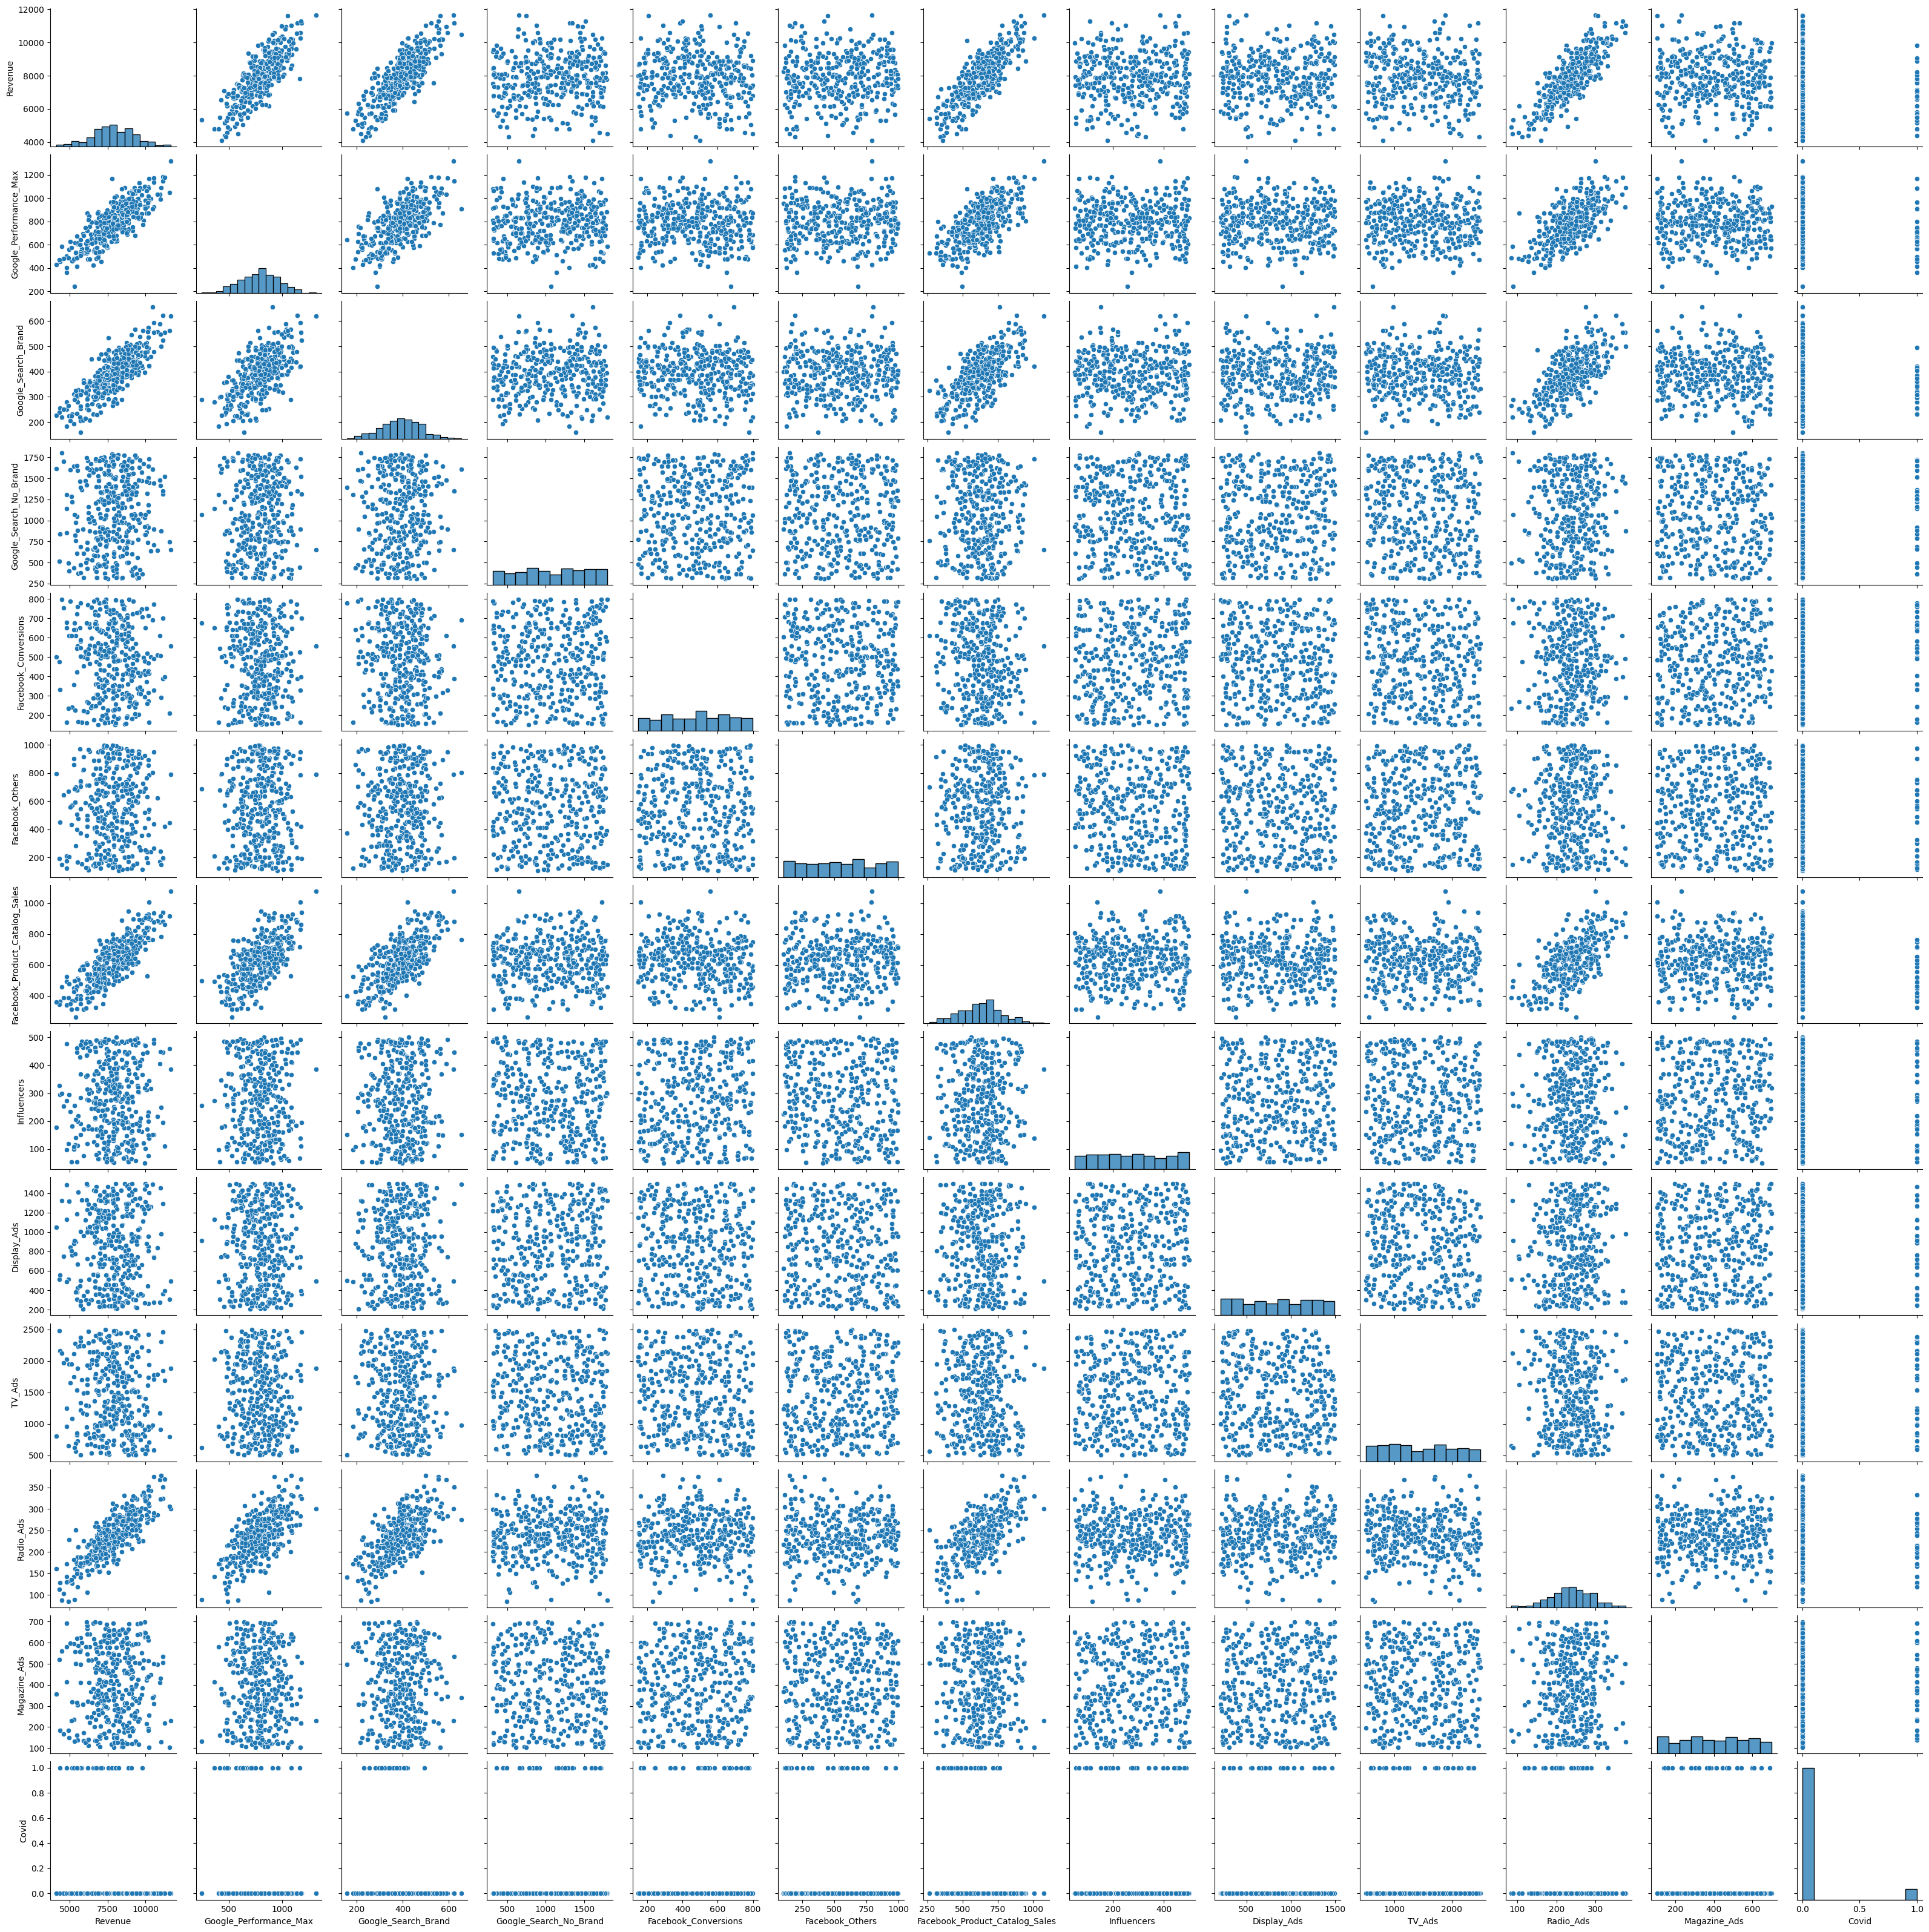

In [4]:
sns.pairplot(data=df)

In [5]:
# --- Adstock Transformation ---
#This function  accept a dictionary of decay rates
def adstock_transform(series, decay_rate):
    """Applies a geometrically decaying adstock transformation."""
    adstock = series.copy()
    for i in range(1, len(adstock)):
        adstock.iloc[i] += adstock.iloc[i - 1] * decay_rate
    return adstock

marketing_channels = [
    'Google_Performance_Max', 'Google_Search_Brand', 'Google_Search_No_Brand', 'Facebook_Conversions', 'Facebook_Others',
    'Facebook_Product_Catalog_Sales', 'Influencers', 'Display_Ads', 'TV_Ads', 'Radio_Ads', 'Magazine_Ads'
]

In [6]:
# ---FINDING OPTIMAL ADSTOCK DECAY RATES ---
print("--- Finding Optimal Adstock Decay Rates ---")
optimal_decay_rates = {}
decay_rates_grid = np.arange(0.1, 1.0, 0.1)
y_col = 'Revenue'

# Temporarily use a time-based train/test split for finding decay rates
split_date_temp = '2022-12-16' # Use the same split date as the final model
df_train_temp = df.loc[df.index < split_date_temp].copy()

# Iterate through each channel to find its best decay rate
for channel in marketing_channels:
    best_rmse = float('inf')
    best_rate = None
    
    # We will use TimeSeriesSplit for cross-validation within the training data
    tscv = TimeSeriesSplit(n_splits=5)
    
    for rate in decay_rates_grid:
        # Create a temporary adstocked column for this specific rate
        df_temp_adstocked = adstock_transform(df_train_temp[channel], rate)
        
        # Prepare data for cross-validation
        X_temp = pd.DataFrame({'adstock_channel': df_temp_adstocked})
        y_temp = df_train_temp[y_col]
        
        rmse_scores = []
        for train_index, val_index in tscv.split(X_temp):
            X_train_fold, X_val_fold = X_temp.iloc[train_index], X_temp.iloc[val_index]
            y_train_fold, y_val_fold = y_temp.iloc[train_index], y_temp.iloc[val_index]
            
            # Use a simple Linear Regression model to find the best decay rate
            model = sm.OLS(y_train_fold, sm.add_constant(X_train_fold)).fit()
            y_pred_val = model.predict(sm.add_constant(X_val_fold))
            rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, y_pred_val)))
        
        avg_rmse = np.mean(rmse_scores)
        
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_rate = rate
    
    optimal_decay_rates[channel] = best_rate
    print(f"Optimal decay rate for {channel}: {best_rate:.2f} (Avg. RMSE: ${best_rmse:,.2f})")
print("-" * 50)

--- Finding Optimal Adstock Decay Rates ---
Optimal decay rate for Google_Performance_Max: 0.10 (Avg. RMSE: $847.93)
Optimal decay rate for Google_Search_Brand: 0.20 (Avg. RMSE: $801.66)
Optimal decay rate for Google_Search_No_Brand: 0.90 (Avg. RMSE: $1,414.00)
Optimal decay rate for Facebook_Conversions: 0.90 (Avg. RMSE: $1,415.08)
Optimal decay rate for Facebook_Others: 0.90 (Avg. RMSE: $1,388.03)
Optimal decay rate for Facebook_Product_Catalog_Sales: 0.20 (Avg. RMSE: $785.75)
Optimal decay rate for Influencers: 0.90 (Avg. RMSE: $1,424.28)
Optimal decay rate for Display_Ads: 0.90 (Avg. RMSE: $1,399.17)
Optimal decay rate for TV_Ads: 0.90 (Avg. RMSE: $1,423.42)
Optimal decay rate for Radio_Ads: 0.20 (Avg. RMSE: $803.51)
Optimal decay rate for Magazine_Ads: 0.90 (Avg. RMSE: $1,401.35)
--------------------------------------------------


In [7]:
# --- Apply Adstock with Optimal Rates to the full DataFrame ---
for col in marketing_channels:
    rate = optimal_decay_rates[col]
    df[f'adstock_{col}'] = adstock_transform(df[col], rate)

df.head()

,Revenue,Google_Performance_Max,Google_Search_Brand,Google_Search_No_Brand,Facebook_Conversions,Facebook_Others,Facebook_Product_Catalog_Sales,Influencers,Display_Ads,TV_Ads,...,adstock_Google_Search_Brand,adstock_Google_Search_No_Brand,adstock_Facebook_Conversions,adstock_Facebook_Others,adstock_Facebook_Product_Catalog_Sales,adstock_Influencers,adstock_Display_Ads,adstock_TV_Ads,adstock_Radio_Ads,adstock_Magazine_Ads
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,5796.714153,565.844985,322.220135,1362.108867,163.379921,152.275251,585.579521,486.459433,1326.028990,1702.230023,...,322.220135,1362.108867,163.379921,152.275251,585.579521,486.459433,1326.028990,1702.230023,166.876823,599.465584
2022-01-02,5165.863043,458.498491,232.034662,1217.779342,240.671009,572.280788,367.558630,181.465092,761.528524,1082.458280,...,296.478689,2443.677322,387.712939,709.328514,484.674534,619.278582,1954.954615,2614.465301,160.628771,859.336132
2022-01-03,6965.648769,673.987247,351.658849,1723.328306,777.660821,646.790367,443.272047,413.778807,421.681361,630.103186,...,410.954586,3922.637896,1126.602466,1285.186030,540.206953,971.129530,2181.140514,2983.121957,224.763735,1056.170780
2022-01-04,5710.922590,600.195659,253.768143,688.169972,580.639485,545.659219,375.149632,190.269984,244.705077,2318.640804,...,335.959060,4218.544079,1594.581704,1702.326646,483.191022,1064.286562,2207.731540,5003.450565,211.427763,1362.594515
2022-01-05,4371.813951,456.867519,255.514027,835.129990,332.607431,449.809561,363.454579,294.213237,552.753741,2157.475018,...,322.705839,4631.819661,1767.730965,1981.903542,460.092783,1252.071143,2539.712128,6660.580526,169.970523,1410.889599


In [8]:
# --- Train/Test Split ---
split_date = '2022-12-16'
train_df = df.loc[df.index < split_date].copy()
test_df = df.loc[df.index >= split_date].copy()

# Define features (X) and target (y)
X_cols = [f'adstock_{col}' for col in marketing_channels] + ['Covid']
y_col = 'Revenue'

X_train, y_train = train_df[X_cols], train_df[y_col]
X_test, y_test = test_df[X_cols], test_df[y_col]
X_test.shape, X_train.shape, y_train.shape, y_test.shape

((16, 12), (349, 12), (349,), (16,))

In [9]:
# --- Multicollinearity Check using VIF ---
print("\n--- Multicollinearity Check with VIF ---")
# Use a copy to avoid modifying the original dataframe
X_train_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data['Variable'] = X_train_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]
print(vif_data.round(2))
print("Note: A VIF score > 5 indicates potential multicollinearity.")
print("-" * 50)


--- Multicollinearity Check with VIF ---
                                  Variable     VIF
0                                    const  215.35
1           adstock_Google_Performance_Max    2.42
2              adstock_Google_Search_Brand    2.72
3           adstock_Google_Search_No_Brand    1.76
4             adstock_Facebook_Conversions    2.21
5                  adstock_Facebook_Others    3.42
6   adstock_Facebook_Product_Catalog_Sales    2.70
7                      adstock_Influencers    2.16
8                      adstock_Display_Ads    1.97
9                           adstock_TV_Ads    1.92
10                       adstock_Radio_Ads    2.60
11                    adstock_Magazine_Ads    2.54
12                                   Covid    2.87
Note: A VIF score > 5 indicates potential multicollinearity.
--------------------------------------------------


In [10]:
# --- OLS Regression Model ---
print("\n--- OLS Regression Results ---")
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())


--- OLS Regression Results ---
                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     208.5
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          1.40e-147
Time:                        14:54:48   Log-Likelihood:                -2648.4
No. Observations:                 349   AIC:                             5323.
Df Residuals:                     336   BIC:                             5373.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [137]:
##OLS Interpretation
contributions = ols_model.params.drop('const') * X_train_sm.drop('const', axis=1)
contributions_lower = ols_model.conf_int()[0].drop('const')*X_train_sm.drop('const', axis=1)
contributions_upper = ols_model.conf_int()[1].drop('const')*X_train_sm.drop('const', axis=1)
total_contributions = contributions.sum()
total_contributions_lower = contributions_lower.sum()
total_contributions_upper = contributions_upper.sum()
total_revenue = y_train.sum()

print("\n--- OLS Marketing Mix Model Interpretation ---")
print("Total Revenue Explained by Model:", total_contributions.sum())
print("Total Actual Revenue:", total_revenue)
print('\nPercentage contributions per channel:')

channel_percentages = {}
channel_percentages_lower = {}
channel_percentages_upper = {}
for channel in total_contributions.drop('Covid').index:
    percentage = (total_contributions[channel] / total_contributions.sum()) * 100
    percentage_lower = (total_contributions_lower[channel] / total_contributions.sum())*100
    percentage_upper = (total_contributions_upper[channel] / total_contributions.sum())*100
    channel_percentages[channel] = percentage
    channel_percentages_lower[channel] = percentage_lower
    channel_percentages_upper[channel] = percentage_upper
    print(f"{channel}: {percentage:.2f}%")


--- OLS Marketing Mix Model Interpretation ---
Total Revenue Explained by Model: 2595616.7199443486
Total Actual Revenue: 2730916.652013

Percentage contributions per channel:
adstock_Google_Performance_Max: 24.28%
adstock_Google_Search_Brand: 23.14%
adstock_Google_Search_No_Brand: 5.43%
adstock_Facebook_Conversions: -4.72%
adstock_Facebook_Others: -3.80%
adstock_Facebook_Product_Catalog_Sales: 25.34%
adstock_Influencers: -1.80%
adstock_Display_Ads: 1.58%
adstock_TV_Ads: -0.91%
adstock_Radio_Ads: 30.12%
adstock_Magazine_Ads: 1.40%


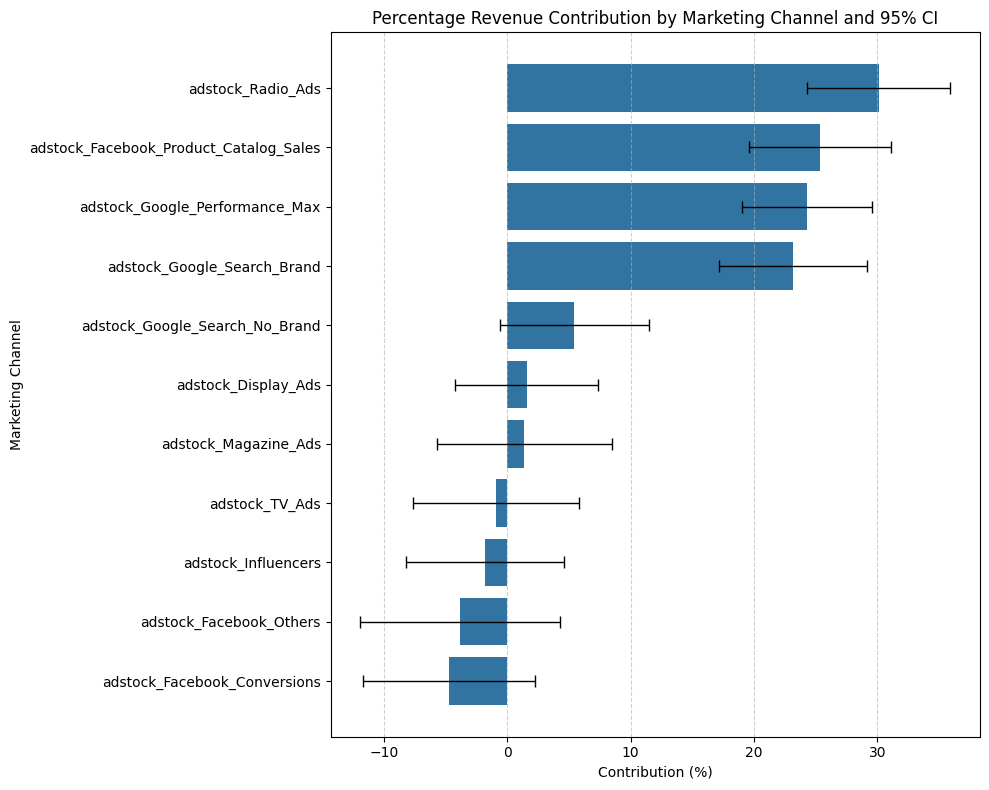

In [135]:
contributions_df = pd.DataFrame(list(channel_percentages.items()), columns=['Channel', 'Contribution_Percentage'])
contributions_df['Contribution_Percentage_lower'] = list(channel_percentages_lower.values())
contributions_df['Contribution_Percentage_upper'] = list(channel_percentages_upper.values())

contributions_df = contributions_df.sort_values(by='Contribution_Percentage', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Contribution_Percentage', y='Channel', data=contributions_df)

x = contributions_df['Contribution_Percentage'].values
xerr_left  = x - contributions_df['Contribution_Percentage_lower'].values
xerr_right = contributions_df['Contribution_Percentage_upper'].values - x
xerr = np.vstack([xerr_left, xerr_right])

# y positions: seaborn draws bars in order
y = np.arange(len(contributions_df))

# add horizontal error bars
plt.errorbar(x, y, xerr=xerr, fmt='none', ecolor='black', capsize=4, linewidth=1)


plt.title('Percentage Revenue Contribution by Marketing Channel and 95% CI')
plt.xlabel('Contribution (%)')
plt.ylabel('Marketing Channel')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [12]:
# OLS Evaluation on Test Set
X_test_sm = sm.add_constant(X_test)
y_pred_ols = ols_model.predict(X_test_sm)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)

print("\n--- OLS Model Evaluation on Test Set ---")
print(f'Root Mean Squared Error (RMSE): ${rmse_ols:,.2f}')
print(f'R-squared (R^2): {r2_ols:.4f}')
print("-" * 50)


--- OLS Model Evaluation on Test Set ---
Root Mean Squared Error (RMSE): $470.30
R-squared (R^2): 0.8599
--------------------------------------------------


In [13]:
# --- Ridge Regression Implementation ---
print("\n--- Ridge Regression Implementation ---")
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Find the best alpha using TimeSeriesSplit Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {'alpha': np.logspace(-4, 4, 100)}
ridge_model = Ridge()
grid_search = GridSearchCV(ridge_model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha found by TimeSeriesSplit CV: {best_alpha:.4f}")


--- Ridge Regression Implementation ---
Optimal Alpha found by TimeSeriesSplit CV: 12.3285


In [14]:
# Fit the final Ridge model with the best alpha
final_ridge_model = Ridge(alpha=best_alpha)
final_ridge_model.fit(X_train_scaled, y_train)

# Evaluate the Ridge Model on the Test Set
y_pred_ridge = final_ridge_model.predict(X_test_scaled)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n--- Ridge Model Evaluation on Test Set ---")
print(f'Root Mean Squared Error (RMSE): ${rmse_ridge:,.2f}')
print(f'R-squared (R^2): {r2_ridge:.4f}')



--- Ridge Model Evaluation on Test Set ---
Root Mean Squared Error (RMSE): $480.37
R-squared (R^2): 0.8539


In [15]:
final_ridge_model.coef_

array([363.38321695, 327.97636595,  56.25059063, -47.19757675,
       -36.55871222, 366.16929776, -18.80083129,  20.76853846,
       -10.76022765, 419.20271075,  13.5931819 , -12.65373275])

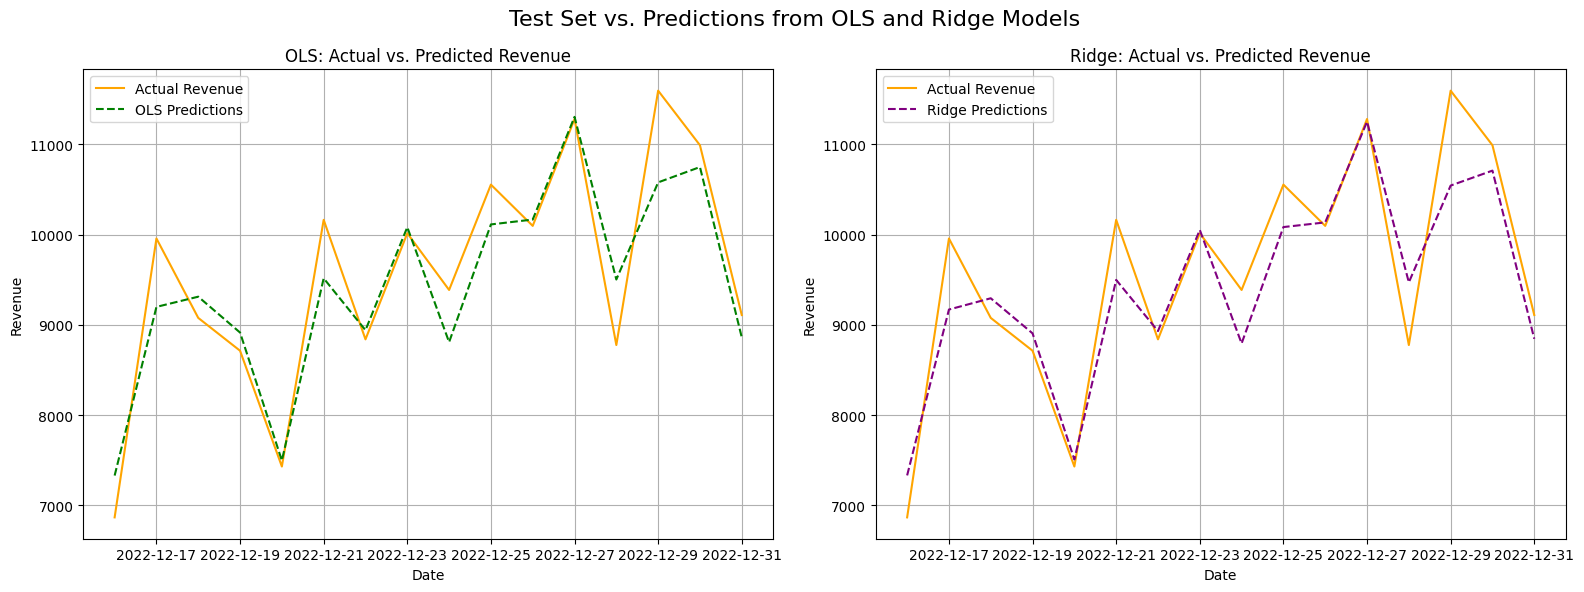

In [136]:
# --- Visualizing Model Evaluation on Test Set ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# OLS Plot
ax1.plot(y_test.index, y_test, label='Actual Revenue', color='orange')
ax1.plot(y_pred_ols.index, y_pred_ols, label='OLS Predictions', color='green', linestyle='--')
ax1.set_title('OLS: Actual vs. Predicted Revenue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Revenue')
ax1.legend()
ax1.grid(True)

# Ridge Plot
ax2.plot(y_test.index, y_test, label='Actual Revenue', color='orange')
ax2.plot(y_test.index, y_pred_ridge, label='Ridge Predictions', color='purple', linestyle='--')
ax2.set_title('Ridge: Actual vs. Predicted Revenue')
ax2.set_xlabel('Date')
ax2.set_ylabel('Revenue')
ax2.legend()
ax2.grid(True)

fig.suptitle('Test Set vs. Predictions from OLS and Ridge Models', fontsize=16)
plt.tight_layout()
plt.show()

Ridge regression does not improve on normal regression.

Summary and conclusions:

* Reliable positive drivers: Radio Ads, Facebook Product Catalog, Google Performance Max - all have significant positive coefficients ($p\approx 0.000$, CIs exclude zero), so they are robustly associated with higher revenue in this model

* Negatives inconclusive: Several channels show negative point estimates (Facebook conversions, Facebook Others, Influencers, TV Ads), but ther are not statistically significant (95% CIs include zero), so there's not reliable evidence they reduce revenue.

* Multicollinearity not the main issue: Feature VIFs are modest ($\leq 3.5$).

* Actionable next steps before budget decisions:  a more robust analysis is needed before making causal decisions.